# **Project: Amazon Product Recommendation System**

Welcome to the project on Recommendation Systems. We will work with the Amazon product reviews dataset for this project. The dataset contains ratings of different electronic products. It does not include information about the products or reviews to avoid bias while building the model.

--------------
## **Context:**
--------------

Today, information is growing exponentially with volume, velocity and variety throughout the globe. This has lead to information overload, and too many choices for the consumer of any business. It represents a real dilemma for these consumers and they often turn to denial. Recommender Systems are one of the best tools that help recommending products to consumers while they are browsing online. Providing personalized recommendations which is most relevant for the user is what's most likely to keep them engaged and help business.

E-commerce websites like Amazon, Walmart, Target and Etsy use different recommendation models to provide personalized suggestions to different users. These companies spend millions of dollars to come up with algorithmic techniques that can provide personalized recommendations to their users.

Amazon, for example, is well-known for its accurate selection of recommendations in its online site. Amazon's recommendation system is capable of intelligently analyzing and predicting customers' shopping preferences in order to offer them a list of recommended products. Amazon's recommendation algorithm is therefore a key element in using AI to improve the personalization of its website. For example, one of the baseline recommendation models that Amazon uses is item-to-item collaborative filtering, which scales to massive data sets and produces high-quality recommendations in real-time.

----------------
## **Objective:**
----------------

You are a Data Science Manager at Amazon, and have been given the task of building a recommendation system to recommend products to customers based on their previous ratings for other products. You have a collection of labeled data of Amazon reviews of products. The goal is to extract meaningful insights from the data and build a recommendation system that helps in recommending products to online consumers.

-----------------------------
## **Dataset:**
-----------------------------

The Amazon dataset contains the following attributes:

- **userId:** Every user identified with a unique id
- **productId:** Every product identified with a unique id
- **Rating:** The rating of the corresponding product by the corresponding user
- **timestamp:** Time of the rating. We **will not use this column** to solve the current problem

**Note:** The code has some user defined functions that will be usefull while making recommendations and measure model performance, you can use these functions or can create your own functions.

Sometimes, the installation of the surprise library, which is used to build recommendation systems, faces issues in Jupyter. To avoid any issues, it is advised to use **Google Colab** for this project.

Let's start by mounting the Google drive on Colab.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Installing surprise library**

In [ ]:
!pip install surprise

## **Importing the necessary libraries and overview of the dataset**

In [ ]:
# Used to ignore the warning given as output of the code
import warnings
warnings.filterwarnings('ignore')

# Libraries of python for numeric and dataframe computations
import numpy as np
import pandas as pd

# Libraries for data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# A dictionary output that does not raise a key error
from collections import defaultdict

# A performance metrics in sklearn
from sklearn.metrics import mean_squared_error

### **Loading the data**
- Import the Dataset
- Add column names ['user_id', 'prod_id', 'rating', 'timestamp']
- Drop the column timestamp
- Copy the data to another DataFrame called **df**

In [ ]:
#Loading data from drive into a DataFrame
data = pd.read_csv('/content/drive/MyDrive/DSML/Recommendation/ratings_Electronics.csv')

# Add column names
data.columns = ['user_id', 'prod_id', 'rating', 'timestamp']

# Drop the 'timestamp' column
data.drop('timestamp', axis=1, inplace=True)

# Copy the data to another DataFrame called df
df = data.copy()

**As this dataset is very large and has 7,824,482 observations, it is not computationally possible to build a model using this. Moreover, many users have only rated a few products and also some products are rated by very few users. Hence, we can reduce the dataset by considering certain logical assumptions.**

Here, we will be taking users who have given at least 50 ratings, and the products that have at least 5 ratings, as when we shop online we prefer to have some number of ratings of a product.

In [ ]:
# Get the column containing the users
users = df.user_id

# Create a dictionary from users to their number of ratings
ratings_count = dict()

for user in users:

    # If we already have the user, just add 1 to their rating count
    if user in ratings_count:
        ratings_count[user] += 1

    # Otherwise, set their rating count to 1
    else:
        ratings_count[user] = 1

In [ ]:
# We want our users to have at least 50 ratings to be considered
RATINGS_CUTOFF = 50

remove_users = []

for user, num_ratings in ratings_count.items():
    if num_ratings < RATINGS_CUTOFF:
        remove_users.append(user)

df = df.loc[ ~ df.user_id.isin(remove_users)]

In [ ]:
# Get the column containing the products
prods = df.prod_id

# Create a dictionary from products to their number of ratings
ratings_count = dict()

for prod in prods:

    # If we already have the product, just add 1 to its rating count
    if prod in ratings_count:
        ratings_count[prod] += 1

    # Otherwise, set their rating count to 1
    else:
        ratings_count[prod] = 1

In [ ]:
# We want our item to have at least 5 ratings to be considered
RATINGS_CUTOFF = 5

remove_users = []

for user, num_ratings in ratings_count.items():
    if num_ratings < RATINGS_CUTOFF:
        remove_users.append(user)

df_final = df.loc[~ df.prod_id.isin(remove_users)]

In [ ]:
# Print a few rows of the imported dataset
df_final.head()

,user_id,prod_id,rating
1309,A3LDPF5FMB782Z,1400501466,5.0
1321,A1A5KUIIIHFF4U,1400501466,1.0
1334,A2XIOXRRYX0KZY,1400501466,3.0
1450,AW3LX47IHPFRL,1400501466,5.0
1455,A1E3OB6QMBKRYZ,1400501466,1.0


## **Exploratory Data Analysis**

### **Shape of the data**

### **Check the number of rows and columns and provide observations.**

In [ ]:
# Check the number of rows and columns and provide observations

num_rows, num_columns = df_final.shape

# Print the results
print(f"Number of rows: {num_rows}")
print(f"Number of columns: {num_columns}")

Number of rows: 65290
Number of columns: 3


**Observations:**

The number of rows indicates the total number of records or data points in our dataset.
Originally we had 7,824,482 records and now we dropped to 65,290 records that fits our restrictions.

The number of columns represents the features or variables present in our dataset. We are going to be working with 3 features.


### **Data types**

In [ ]:
# Check Data types and provide observations
print(df_final.dtypes)

user_id     object
prod_id     object
rating     float64
dtype: object


**Observations:**
user_id and prod_id are represented as an 'object' data type, the values here are string.
The 'rating' column is represented as 'float64', numeric values, for storing the ratings.

### **Checking for missing values**

In [ ]:
# Check for missing values present and provide observations
print(df_final.isnull().sum())

user_id    0
prod_id    0
rating     0
dtype: int64


**Observations:**

No missing values on the data, awesome!


### **Summary Statistics**

In [ ]:
# Summary statistics of 'rating' variable and provide observations
print(df_final['rating'].describe())

count    65290.000000
mean         4.294808
std          0.988915
min          1.000000
25%          4.000000
50%          5.000000
75%          5.000000
max          5.000000
Name: rating, dtype: float64


**Observations:**
The mean is close to 4.29. Which means that users tend to give ratings over 4.
The 25 percentile indicates onl 25% of the ratings were 4 or lower. The median rating is 5 and the 75 percetile is all 5 ratings.

### **Checking the rating distribution**

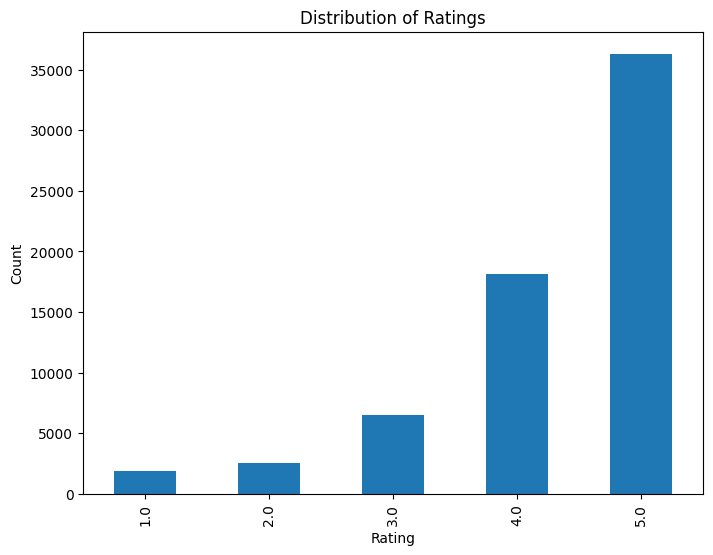

In [ ]:
# Create the bar plot and provide observations

# Bar plot of the 'rating' variable
plt.figure(figsize=(8, 6))
df_final['rating'].value_counts().sort_index().plot(kind='bar')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.title('Distribution of Ratings')
plt.show()


**Observations:**
The barplot illustrates previous observations. most ratings are 5.

### **Checking the number of unique users and items in the dataset**

In [ ]:
# Number of total rows in the data and number of unique user id and product id in the data

# Number of total rows in the data
total_rows = len(df_final)

# Number of unique user IDs
unique_user_ids = df_final['user_id'].nunique()

# Number of unique product IDs
unique_product_ids = df_final['prod_id'].nunique()

# Print the results
print(f"Number of total rows in the data: {total_rows}")
print(f"Number of unique user IDs: {unique_user_ids}")
print(f"Number of unique product IDs: {unique_product_ids}")

Number of total rows in the data: 65290
Number of unique user IDs: 1540
Number of unique product IDs: 5689


****
The data has 65290 observations. They come from 1540 users and contains their ratings for 5689 unique products

### **Users with the most number of ratings**

In [ ]:
# Top 10 users based on the number of ratings

# Group the data by 'user_id' and count the number of ratings for each user
user_ratings_count = df_final.groupby('user_id')['rating'].count()

# Sort the users by the number of ratings in descending order
top_10_users = user_ratings_count.sort_values(ascending=False).head(10)

# Print the top 10 users
print("Top 10 users based on the number of ratings:")
print(top_10_users)


Top 10 users based on the number of ratings:
user_id
ADLVFFE4VBT8      295
A3OXHLG6DIBRW8    230
A1ODOGXEYECQQ8    217
A36K2N527TXXJN    212
A25C2M3QF9G7OQ    203
A680RUE1FDO8B     196
A22CW0ZHY3NJH8    193
A1UQBFCERIP7VJ    193
AWPODHOB4GFWL     184
A3LGT6UZL99IW1    179
Name: rating, dtype: int64


**Observations:**

These are the users that hae given more rating. They can be considered higly engajed users.

# **Now that we have explored and prepared the data, let's build the first recommendation system.**

## **Model 1: Rank Based Recommendation System**

In [ ]:
# Calculate the average rating for each product
average_rating = df_final.groupby('prod_id')['rating'].mean()

# Calculate the count of ratings for each product
rating_count = df_final.groupby('prod_id')['rating'].count()

# Create a dataframe with calculated average and count of ratings
final_rating = pd.DataFrame({'Average_Rating': average_rating, 'Rating_Count': rating_count})

# Sort the dataframe by average of ratings in the descending order
final_rating = final_rating.sort_values(by=['Average_Rating','Rating_Count'], ascending=False)

# See the first five records of the "final_rating" dataset
print(final_rating.head())


            Average_Rating  Rating_Count
prod_id                                 
B000FQ2JLW             5.0            19
B00ISFNSBW             5.0            18
B000IJY8DS             5.0            17
B001TH7GUA             5.0            17
B00HZWJGS8             5.0            17


In [ ]:
# Defining a function to get the top n products based on the highest average rating and minimum interactions
# Finding products with minimum number of interactions
# Sorting values with respect to average rating

def get_top_n_products(df, n=10, min_interactions=10):
    """
    Get the top n products based on the highest average rating and minimum interactions.

    Args:
    - df: DataFrame containing product ratings and information.
    - n: Number of top products to retrieve (default is 10).
    - min_interactions: Minimum number of interactions a product should have to be considered (default is 10).

    Returns:
    - top_products: DataFrame containing the top n products based on the criteria.
    """
    # Calculate the average rating for each product
    average_rating = df.groupby('prod_id')['rating'].mean()

    # Calculate the count of ratings for each product
    rating_count = df.groupby('prod_id')['rating'].count()

    # Create a DataFrame with average and count of ratings
    final_rating = pd.DataFrame({'Average_Rating': average_rating, 'Rating_Count': rating_count})

    # Filter products with minimum interactions
    final_rating = final_rating[final_rating['Rating_Count'] >= min_interactions]

    # Sort the DataFrame by average rating in descending order
    final_rating = final_rating.sort_values(by='Average_Rating', ascending=False)

    # Get the top n products
    top_products = final_rating.head(n)

    return top_products

# Example usage:
top_n_products = get_top_n_products(df_final, n=10, min_interactions=10)
print(top_n_products)


            Average_Rating  Rating_Count
prod_id                                 
B00L3YHF6O             5.0            14
B00HG1L334             5.0            16
B001TH7GUA             5.0            17
B00C20KWP4             5.0            10
B004Y1AYAC             5.0            11
B00BLCVD9I             5.0            11
B0058G40O8             5.0            12
B00FZ9SMVU             5.0            10
B005GI2VMG             5.0            10
B0000B006W             5.0            12


### **Recommending top 5 products with 50 minimum interactions based on popularity**

In [ ]:
# Use the get_top_n_products function to recommend top 5 products with a minimum of 50 interactions
top_5_popular_products = get_top_n_products(df_final, n=5, min_interactions=50)

# Print the top 5 popular products
print("Top 5 Popular Products with at Least 50 Interactions:")
print(top_5_popular_products)

Top 5 Popular Products with at Least 50 Interactions:
            Average_Rating  Rating_Count
prod_id                                 
B001TH7GUU        4.871795            78
B003ES5ZUU        4.864130           184
B0019EHU8G        4.855556            90
B006W8U2MU        4.824561            57
B000QUUFRW        4.809524            84


### **Recommending top 5 products with 100 minimum interactions based on popularity**

In [ ]:
# Use the get_top_n_products function to recommend top 5 products with a minimum of 100 interactions
top_5_popular_products = get_top_n_products(df_final, n=5, min_interactions=100)

# Print the top 5 popular products
print("Top 5 Popular Products with at Least 100 Interactions:")
print(top_5_popular_products)

Top 5 Popular Products with at Least 100 Interactions:
            Average_Rating  Rating_Count
prod_id                                 
B003ES5ZUU        4.864130           184
B000N99BBC        4.772455           167
B002WE6D44        4.770000           100
B007WTAJTO        4.701220           164
B002V88HFE        4.698113           106


We have recommended the **top 5** products by using the popularity recommendation system. Now, let's build a recommendation system using **collaborative filtering.**

## **Model 2: Collaborative Filtering Recommendation System**

### **Building a baseline user-user similarity based recommendation system**

- Below, we are building **similarity-based recommendation systems** using `cosine` similarity and using **KNN to find similar users** which are the nearest neighbor to the given user.  
- We will be using a new library, called `surprise`, to build the remaining models. Let's first import the necessary classes and functions from this library.

In [ ]:
# To compute the accuracy of models
from surprise import accuracy

# Class is used to parse a file containing ratings, data should be in structure - user ; item ; rating
from surprise.reader import Reader

# Class for loading datasets
from surprise.dataset import Dataset

# For tuning model hyperparameters
from surprise.model_selection import GridSearchCV

# For splitting the rating data in train and test datasets
from surprise.model_selection import train_test_split

# For implementing similarity-based recommendation system
from surprise.prediction_algorithms.knns import KNNBasic

# For implementing matrix factorization based recommendation system
from surprise.prediction_algorithms.matrix_factorization import SVD

# for implementing K-Fold cross-validation
from surprise.model_selection import KFold

# For implementing clustering-based recommendation system
from surprise import CoClustering

**Before building the recommendation systems, let's  go over some basic terminologies we are going to use:**

**Relevant item:** An item (product in this case) that is actually **rated higher than the threshold rating** is relevant, if the **actual rating is below the threshold then it is a non-relevant item**.  

**Recommended item:** An item that's **predicted rating is higher than the threshold is a recommended item**, if the **predicted rating is below the threshold then that product will not be recommended to the user**.  


**False Negative (FN):** It is the **frequency of relevant items that are not recommended to the user**. If the relevant items are not recommended to the user, then the user might not buy the product/item. This would result in the **loss of opportunity for the service provider**, which they would like to minimize.

**False Positive (FP):** It is the **frequency of recommended items that are actually not relevant**. In this case, the recommendation system is not doing a good job of finding and recommending the relevant items to the user. This would result in **loss of resources for the service provider**, which they would also like to minimize.

**Recall:** It is the **fraction of actually relevant items that are recommended to the user**, i.e., if out of 10 relevant products, 6 are recommended to the user then recall is 0.60. Higher the value of recall better is the model. It is one of the metrics to do the performance assessment of classification models.

**Precision:** It is the **fraction of recommended items that are relevant actually**, i.e., if out of 10 recommended items, 6 are found relevant by the user then precision is 0.60. The higher the value of precision better is the model. It is one of the metrics to do the performance assessment of classification models.

**While making a recommendation system, it becomes customary to look at the performance of the model. In terms of how many recommendations are relevant and vice-versa, below are some most used performance metrics used in the assessment of recommendation systems.**

### **Precision@k, Recall@ k, and F1-score@k**

**Precision@k** - It is the **fraction of recommended items that are relevant in `top k` predictions**. The value of k is the number of recommendations to be provided to the user. One can choose a variable number of recommendations to be given to a unique user.  


**Recall@k** - It is the **fraction of relevant items that are recommended to the user in `top k` predictions**.

**F1-score@k** - It is the **harmonic mean of Precision@k and Recall@k**. When **precision@k and recall@k both seem to be important** then it is useful to use this metric because it is representative of both of them.

### **Some useful functions**

- Below function takes the **recommendation model** as input and gives the **precision@k, recall@k, and F1-score@k** for that model.  
- To compute **precision and recall**, **top k** predictions are taken under consideration for each user.
- We will use the precision and recall to compute the F1-score.

In [ ]:
def precision_recall_at_k(model, k = 10, threshold = 3.5):
    """Return precision and recall at k metrics for each user"""

    # First map the predictions to each user
    user_est_true = defaultdict(list)

    # Making predictions on the test data
    predictions = model.test(testset)

    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key = lambda x: x[0], reverse = True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        # When n_rec_k is 0, Precision is undefined. Therefore, we are setting Precision to 0 when n_rec_k is 0

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of relevant items that are recommended
        # When n_rel is 0, Recall is undefined. Therefore, we are setting Recall to 0 when n_rel is 0

        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

    # Mean of all the predicted precisions are calculated.
    precision = round((sum(prec for prec in precisions.values()) / len(precisions)), 3)

    # Mean of all the predicted recalls are calculated.
    recall = round((sum(rec for rec in recalls.values()) / len(recalls)), 3)

    accuracy.rmse(predictions)

    print('Precision: ', precision) # Command to print the overall precision

    print('Recall: ', recall) # Command to print the overall recall

    print('F_1 score: ', round((2*precision*recall)/(precision+recall), 3)) # Formula to compute the F-1 score

**Hints:**

- To compute **precision and recall**, a **threshold of 3.5 and k value of 10 can be considered for the recommended and relevant ratings**.
- Think about the performance metric to choose.

Below we are loading the **`rating` dataset**, which is a **pandas DataFrame**, into a **different format called `surprise.dataset.DatasetAutoFolds`**, which is required by this library. To do this, we will be **using the classes `Reader` and `Dataset`.**

In [ ]:
# Instantiating Reader scale with expected rating scale

# Define the rating scale (1 to 5 in your case)
reader = Reader(rating_scale=(1, 5))

# Loading the rating dataset

# Load the dataset from a Pandas DataFrame
data = Dataset.load_from_df(df_final[['user_id', 'prod_id', 'rating']], reader)

# Splitting the data into train and test datasets
# (80% train, 20% test)

trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

Now, we are **ready to build the first baseline similarity-based recommendation system** using the cosine similarity.

### **Building the user-user Similarity-based Recommendation System**

In [ ]:
# Declaring the similarity options
sim_options = {
    'name': 'cosine',
    'user_based': True  # User-User similarity
}

# Initialize the KNNBasic model using sim_options declared, Verbose = False, and setting random_state = 1
user_user_model = KNNBasic(sim_options=sim_options, verbose=False, random_state=1)

# Fit the model on the training data
user_user_model.fit(trainset)

# Let us compute precision@k, recall@k, and f_1 score using the precision_recall_at_k function defined above
precision_recall_at_k(user_user_model, k=10, threshold=3.5)

RMSE: 1.0012
Precision:  0.855
Recall:  0.858
F_1 score:  0.856


**Observations bold text:__________**

The model with cosine similarity performs reasonably well. It achieves a good balance between precision and recall while maintaining a relatively low RMSE value, indicating that it provides relevant recommendations to users while accurately predicting user ratings.

Let's now **predict rating for a user with `userId=A3LDPF5FMB782Z` and `productId=1400501466`** as shown below. Here the user has already interacted or watched the product with productId '1400501466' and given a rating of 5.

In [ ]:
# Predicting rating for a sample user with an interacted product

# Sample user and product IDs
user_id = 'A3LDPF5FMB782Z'
product_id = '1400501466'

# Predict the rating for the user and product
predicted_rating = user_user_model.predict(user_id, product_id)

# Extract the predicted rating value
predicted_rating_value = predicted_rating.est

# Print the predicted rating
print(f"Predicted Rating for User {user_id} and Product {product_id}: {predicted_rating_value:.2f}")


Predicted Rating for User A3LDPF5FMB782Z and Product 1400501466: 3.40


**Observations:**

This prediction suggests that, based on the user's behavior and similarity to other users, the model estimates that the user is likely to give a rating of around 3.40 to the product '1400501466'.

Below is the **list of users who have not seen the product with product id "1400501466"**.

In [ ]:
# Find unique user_id where prod_id is not equal to "1400501466"

# Filter the DataFrame to exclude rows with prod_id equal to "1400501466"
users_not_seen_product = df_final[df_final['prod_id'] != '1400501466']

# Get the unique user IDs from the filtered DataFrame
unique_users_not_seen_product = users_not_seen_product['user_id'].unique()

# Print the unique user IDs
print("Unique User IDs who have not seen the product with prod_id '1400501466':")
for item in unique_users_not_seen_product:
    print(item)

Unique User IDs who have not seen the product with prod_id '1400501466':
A2ZR3YTMEEIIZ4
A3CLWR1UUZT6TG
A5JLAU2ARJ0BO
A1P4XD7IORSEFN
A341HCMGNZCBIT
A3HPCRD9RX351S
A1DQHS7MOVYYYA
ALUNVOQRXOZIA
A19N3S7CBSU6O7
A3G7BEJJCPD6DS
A2JXS1JII6SAUD
A1C82BC5GNABOA
A1VHCO8RQFIGQJ
A2Z9S2RQD542CP
A2QIC4G483SQQA
A3L6L5O89JTX2T
A1OGCPMSIVK7G4
A18HE80910BTZI
A3F9CBHV4OHFBS
A1T1YSCDW0PD25
ABVYGB2TKBO8F
A11ED8O95W2103
A3NCIN6TNL0MGA
ASHJAZC9OA9NS
A105TOJ6LTVMBG
A14JBDSWKPKTZA
A3QX0ERX4D03TF
A13WREJ05GMRA6
A3N8O68DOEQ2FE
A3J8A5L5AF5TX9
A2HRHF83I3NDGT
A1R3GN9MEJFXM3
A3963R7EPE3A7E
A2JOPUWVV0XQJ3
AAW7X3GRD8GY9
A3V8P0O224OBDB
AY6A8KPYCE6B0
A212MDP6K4VJS5
A28X0LT2100RL1
A1V3TRGWOMA8LC
A1NZLRAZJGD99W
A1522TN5FVJL0Y
A3UXW18DP4WSD6
A3CW0ZLUO5X2B1
A3TBMGNSEQBWIL
AEZJTA4KDIWY8
A22CW0ZHY3NJH8
A2V7EO331SFUF6
A3977M5S0GIG5H
A1F1A0QQP2XVH5
A231WM2Z2JL0U3
A2JWF9IG8PJAOA
A3LWC833HQIG7J
A38RMU1Y5TDP9
A3D822N1K2IAQD
A33775AIB1A664
ARXU3FESTWMJJ
A3A15L96IYUO6V
A3PGVJF37JSHFO
A2WJ5XSE4I9F55
A1V5TRJXTI6F01
ATOKT8QYK967L
ANRS196

* It can be observed from the above list that **user "A34BZM6S9L7QI4" has not seen the product with productId "1400501466"** as this userId is a part of the above list.

**Below we are predicting rating for `userId=A34BZM6S9L7QI4` and `prod_id=1400501466`.**

In [ ]:
# Predicting rating for a sample user with a non interacted product

# Sample user and product IDs
user_id = 'A34BZM6S9L7QI4'
product_id = '1400501466'

# Predict the rating for the user and product
predicted_rating = user_user_model.predict(user_id, product_id)

# Extract the predicted rating value
predicted_rating_value = predicted_rating.est

# Print the predicted rating
print(f"Predicted Rating for User {user_id} and Product {product_id}: {predicted_rating_value:.2f}")



Predicted Rating for User A34BZM6S9L7QI4 and Product 1400501466: 4.29


**Observations:**

The user 'A34BZM6S9L7QI4' is likely to give a rating of around 4.29 to the product '1400501466'. Assuming 4.00 is positive we can recommend this product to the user

### **Improving similarity-based recommendation system by tuning its hyperparameters**

Below, we will be tuning hyperparameters for the `KNNBasic` algorithm. Let's try to understand some of the hyperparameters of the KNNBasic algorithm:

- **k** (int) – The (max) number of neighbors to take into account for aggregation. Default is 40.
- **min_k** (int) – The minimum number of neighbors to take into account for aggregation. If there are not enough neighbors, the prediction is set to the global mean of all ratings. Default is 1.
- **sim_options** (dict) – A dictionary of options for the similarity measure. And there are four similarity measures available in surprise -
    - cosine
    - msd (default)
    - Pearson
    - Pearson baseline

In [ ]:
# Setting up parameter grid to tune the hyperparameters

param_grid = {
    'k': [10, 20, 30, 40],         # Number of neighbors to consider
    'min_k': [1, 2, 5],            # Minimum number of neighbors to consider
    'sim_options': {
        'name': ['cosine', 'msd', 'pearson', 'pearson_baseline'],  # Similarity measures
        'user_based': [True]        # User-User similarity
    }
}

# Performing 3-fold cross-validation to tune the hyperparameters
grid_search = GridSearchCV(KNNBasic, param_grid, measures=['rmse'], cv=3, n_jobs=-1)

# Fitting the data
grid_search.fit(data)

# Best RMSE score
best_rmse = grid_search.best_score['rmse']

# Combination of parameters that gave the best RMSE score
best_params = grid_search.best_params

# Print the results
print(f"Best RMSE Score: {best_rmse}")
print(f"Best Parameters: {best_params}")


Best RMSE Score: 0.9686045392583081
Best Parameters: {'rmse': {'k': 40, 'min_k': 5, 'sim_options': {'name': 'cosine', 'user_based': True}}}


Once the grid search is **complete**, we can get the **optimal values for each of those hyperparameters**.

Now, let's build the **final model by using tuned values of the hyperparameters**, which we received by using **grid search cross-validation**.

In [ ]:
# Using the optimal similarity measure for user-user based collaborative filtering

# Creating an instance of KNNBasic with optimal hyperparameter values
opt_user_user_model = KNNBasic(sim_options={'name': 'cosine', 'user_based': True}, k=40, min_k=3)

# Training the algorithm on the trainset
opt_user_user_model.fit(trainset)

# Let us compute precision@k and recall@k also with k =10
precision_recall_at_k(opt_user_user_model, k=10, threshold=3.5)


Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.9553
Precision:  0.855
Recall:  0.885
F_1 score:  0.87


**Observations:**

the final recommendation model demonstrates improved performance in terms of RMSE and F1 score.

### **Steps:**
- **Predict rating for the user with `userId="A3LDPF5FMB782Z"`, and `prod_id= "1400501466"` using the optimized model**
- **Predict rating for `userId="A34BZM6S9L7QI4"` who has not interacted with `prod_id ="1400501466"`, by using the optimized model**
- **Compare the output with the output from the baseline model**

In [ ]:
# Use sim_user_user_optimized model to recommend for userId "A3LDPF5FMB782Z" and productId 1400501466

user_id_1 = 'A3LDPF5FMB782Z'
product_id_1 = '1400501466'

# Predict the rating for the user and product using the optimized model
predicted_rating_1 = opt_user_user_model.predict(user_id_1, product_id_1)

# Extract the predicted rating value
predicted_rating_value_1 = predicted_rating_1.est

# Print the predicted rating
print(f"Predicted Rating for User {user_id_1} and Product {product_id_1}: {predicted_rating_value_1:.2f}")

Predicted Rating for User A3LDPF5FMB782Z and Product 1400501466: 3.40


In [ ]:
# Use sim_user_user_optimized model to recommend for userId "A34BZM6S9L7QI4" and productId "1400501466"

user_id_2 = 'A34BZM6S9L7QI4'
product_id_2 = '1400501466'

# Predict the rating for the user and product using the optimized model
predicted_rating_2 = opt_user_user_model.predict(user_id_2, product_id_2)

# Extract the predicted rating value
predicted_rating_value_2 = predicted_rating_2.est

# Print the predicted rating
print(f"Predicted Rating for User {user_id_2} and Product {product_id_2}: {predicted_rating_value_2:.2f}")

Predicted Rating for User A34BZM6S9L7QI4 and Product 1400501466: 4.29


**Observations:**____________

We can see an improvment on the new model compared with the previous, may indicate that the user-user recommendation system is better at capturing the user preferences.

### **Identifying similar users to a given user (nearest neighbors)**

We can also find out **similar users to a given user** or its **nearest neighbors** based on this KNNBasic algorithm. Below, we are finding the 5 most similar users to the first user in the list with internal id 0, based on the `msd` distance metric.

In [ ]:
# 0 is the inner id of the above user

# Find the k-nearest neighbors for the target user using the existing model
k_nearest_neighbors = opt_user_user_model.get_neighbors(0, k=5)

# Print the IDs of the k-nearest neighbors
print(f"The 5 most similar users to user with inner ID {0}: {k_nearest_neighbors}")

The 5 most similar users to user with inner ID 0: [6, 7, 17, 26, 32]


### **Implementing the recommendation algorithm based on optimized KNNBasic model**

Below we will be implementing a function where the input parameters are:

- data: A **rating** dataset
- user_id: A user id **against which we want the recommendations**
- top_n: The **number of products we want to recommend**
- algo: the algorithm we want to use **for predicting the ratings**
- The output of the function is a **set of top_n items** recommended for the given user_id based on the given algorithm

In [ ]:
def get_recommendations(data, user_id, top_n, algo):

    # Creating an empty list to store the recommended product ids
    recommendations = []

    # Creating an user item interactions matrix
    user_item_interactions_matrix = data.pivot(index = 'user_id', columns = 'prod_id', values = 'rating')

    # Extracting those product ids which the user_id has not interacted yet
    non_interacted_products = user_item_interactions_matrix.loc[user_id][user_item_interactions_matrix.loc[user_id].isnull()].index.tolist()

    # Looping through each of the product ids which user_id has not interacted yet
    for item_id in non_interacted_products:

        # Predicting the ratings for those non interacted product ids by this user
        est = algo.predict(user_id, item_id).est

        # Appending the predicted ratings
        recommendations.append((item_id, est))

    # Sorting the predicted ratings in descending order
    recommendations.sort(key = lambda x: x[1], reverse = True)

    return recommendations[:top_n] # Returing top n highest predicted rating products for this user

**Predicting top 5 products for userId = "A3LDPF5FMB782Z" with similarity based recommendation system**

In [ ]:
# Making top 5 recommendations for user_id "A3LDPF5FMB782Z" with a similarity-based recommendation engine
# Define the user_id for which you want to make recommendations
user_id = "A3LDPF5FMB782Z"

# Define the number of top recommendations you want (e.g., top 5)
top_n =5

recommendations = get_recommendations(df_final, user_id, top_n, opt_user_user_model)

# Print the recommended items and their predicted ratings
print(f"Top {top_n} Recommended Items for User {user_id}:")
for item_id, estimated_rating in recommendations:
    print(f"Product ID: {item_id}, Predicted Rating: {estimated_rating}")


Top 5 Recommended Items for User A3LDPF5FMB782Z:
Product ID: B00005LENO, Predicted Rating: 5
Product ID: B000067RT6, Predicted Rating: 5
Product ID: B00006HSML, Predicted Rating: 5
Product ID: B00006I53X, Predicted Rating: 5
Product ID: B00006I5J7, Predicted Rating: 5


In [ ]:
# Building the dataframe for above recommendations with columns "prod_id" and "predicted_ratings"

# Create a list of dictionaries with "prod_id" and "predicted_ratings"
recommendations_list = [{"prod_id": product_id, "predicted_ratings": estimated_rating} for product_id, estimated_rating in recommendations]

# Convert the list of dictionaries into a DataFrame
recommendations_df = pd.DataFrame(recommendations_list)

# Print the DataFrame
print(recommendations_df)

      prod_id  predicted_ratings
0  B00005LENO                  5
1  B000067RT6                  5
2  B00006HSML                  5
3  B00006I53X                  5
4  B00006I5J7                  5


### **Item-Item Similarity-based Collaborative Filtering Recommendation System**

* Above we have seen **similarity-based collaborative filtering** where similarity is calculated **between users**. Now let us look into similarity-based collaborative filtering where similarity is seen **between items**.

In [ ]:
# Declare the similarity options for item-item similarity
sim_options = {
    'name': 'cosine',  # You can choose a different similarity measure if desired
    'user_based': False  # We want item-item similarity, so set to False
}

# Create an instance of KNNBasic with the similarity options
item_item_model = KNNBasic(sim_options=sim_options, random_state=1)

# Train the item-item model on the trainset
item_item_model.fit(trainset)

# Make predictions on the testset
test_predictions = item_item_model.test(testset)

# Calculate and print RMSE
precision_recall_at_k(item_item_model, k=10, threshold=3.5)


Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.9950
Precision:  0.838
Recall:  0.845
F_1 score:  0.841


**Observations:**____________

This model has a lower RMSE, suggesting slightly more accurate predictions.
However the User-User model slightly outperforms in temrs of precision, recall and F1 scores. Which means more relevants recommendations

Let's now **predict a rating for a user with `userId = A3LDPF5FMB782Z` and `prod_Id = 1400501466`** as shown below. Here the user has already interacted or watched the product with productId "1400501466".

In [ ]:
# Predicting rating for a sample user with an interacted product

user_id_to_predict = "A3LDPF5FMB782Z"
product_id_to_predict = "1400501466"

# Predicting the rating for the user and product using item_item_model
predicted_rating = item_item_model.predict(user_id_to_predict, product_id_to_predict).est

# Print the predicted rating
print(f"Predicted Rating for User {user_id_to_predict} and Product {product_id_to_predict}: {predicted_rating:.2f}")

Predicted Rating for User A3LDPF5FMB782Z and Product 1400501466: 4.27


**Observations:**____________

The model predicts a rating of 4.27 for this specific user-product interaction. This suggests that, this model gives a higher predicted rating for this user and product


Below we are **predicting rating for the `userId = A34BZM6S9L7QI4` and `prod_id = 1400501466`**.

In [ ]:
# Predicting rating for a sample user with a non interacted product

user_id_to_predict = "A34BZM6S9L7QI4"
product_id_to_predict = "1400501466"

# Predicting the rating for the user and product using the selected model
predicted_rating = item_item_model.predict(user_id_to_predict, product_id_to_predict).est

# Print the predicted rating
print(f"Predicted Rating for User {user_id_to_predict} and Product {product_id_to_predict}: {predicted_rating:.2f}")

Predicted Rating for User A34BZM6S9L7QI4 and Product 1400501466: 4.29


**Observations:**____________

The model predicts a rating of 4.27 for this specific user-product interaction. This suggests that, this model gives the same predicted rating for this user and product

### **Hyperparameter tuning the item-item similarity-based model**
- Use the following values for the param_grid and tune the model.
  - 'k': [10, 20, 30]
  - 'min_k': [3, 6, 9]
  - 'sim_options': {'name': ['msd', 'cosine']
  - 'user_based': [False]
- Use GridSearchCV() to tune the model using the 'rmse' measure
- Print the best score and best parameters

In [ ]:
# Setting up parameter grid to tune the hyperparameters

param_grid = {
    'k': [10, 20, 30],         # Number of neighbors to consider
    'min_k': [3, 6, 9],            # Minimum number of neighbors to consider
    'sim_options': {
        'name': ['cosine', 'msd'],  # Similarity measures
        'user_based': [False]        # User-User similarity
    }
}

# Performing 3-fold cross validation to tune the hyperparameters

grid_search = GridSearchCV(KNNBasic, param_grid, measures=['rmse'], cv=3, n_jobs=-1)

# Fitting the data

grid_search.fit(data)

# Find the best RMSE score

best_rmse = grid_search.best_score['rmse']

# Find the combination of parameters that gave the best RMSE score

best_params = grid_search.best_params

# Print the results
print(f"Best RMSE Score: {best_rmse}")
print(f"Best Parameters: {best_params}")

Best RMSE Score: 0.9748563340223049
Best Parameters: {'rmse': {'k': 30, 'min_k': 6, 'sim_options': {'name': 'msd', 'user_based': False}}}


Once the **grid search** is complete, we can get the **optimal values for each of those hyperparameters as shown above.**

Now let's build the **final model** by using **tuned values of the hyperparameters** which we received by using grid search cross-validation.

### **Use the best parameters from GridSearchCV to build the optimized item-item similarity-based model. Compare the performance of the optimized model with the baseline model.**

In [ ]:
# Using the optimal similarity measure for item-item based collaborative filtering

# Creating an instance of KNNBasic with optimal hyperparameter values
opt_item_item_model = KNNBasic(sim_options={'name': 'msd', 'user_based': False}, k=30, min_k=6)

# Training the algorithm on the trainset
opt_item_item_model.fit(trainset)

# Let us compute precision@k and recall@k also with k =10
precision_recall_at_k(opt_item_item_model, k=10, threshold=3.5)


Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.9576
Precision:  0.839
Recall:  0.88
F_1 score:  0.859


**Observations:**
All metrics improved in relation to the previous item_item_model

### **Steps:**
- **Predict rating for the user with `userId="A3LDPF5FMB782Z"`, and `prod_id= "1400501466"` using the optimized model**
- **Predict rating for `userId="A34BZM6S9L7QI4"` who has not interacted with `prod_id ="1400501466"`, by using the optimized model**
- **Compare the output with the output from the baseline model**

In [ ]:
# Use opt_item_item_optimized model to recommend for userId "A3LDPF5FMB782Z" and productId "1400501466"

# Predicting rating for a sample user with a non interacted product

user_id_to_predict = "A3LDPF5FMB782Z"
product_id_to_predict = "1400501466"

# Predicting the rating for the user and product using the selected model
predicted_rating = opt_item_item_model.predict(user_id_to_predict, product_id_to_predict).est

# Print the predicted rating
print(f"Predicted Rating for User {user_id_to_predict} and Product {product_id_to_predict}: {predicted_rating:.2f}")


Predicted Rating for User A3LDPF5FMB782Z and Product 1400501466: 4.67


In [ ]:
# Use sim_item_item_optimized model to recommend for userId "A34BZM6S9L7QI4" and productId "1400501466"

# Predicting rating for a sample user with a non interacted product

user_id_to_predict = "A34BZM6S9L7QI4"
product_id_to_predict = "1400501466"

# Predicting the rating for the user and product using the selected model
predicted_rating = opt_item_item_model.predict(user_id_to_predict, product_id_to_predict).est

# Print the predicted rating
print(f"Predicted Rating for User {user_id_to_predict} and Product {product_id_to_predict}: {predicted_rating:.2f}")

Predicted Rating for User A34BZM6S9L7QI4 and Product 1400501466: 4.29


**Observations:**

For the first prediction, the model is indicating an even higher rating for the product, the 2nd prediction is the same


### **Identifying similar items to a given item (nearest neighbors)**

We can also find out **similar items** to a given item or its nearest neighbors based on this **KNNBasic algorithm**. Below we are finding the 5 most similar items to the item with internal id 0 based on the `msd` distance metric.

**Predicting top 5 products for userId = "A1A5KUIIIHFF4U" with similarity based recommendation system.**

**Hint:** Use the get_recommendations() function.

In [ ]:
# Making top 5 recommendations for user_id A1A5KUIIIHFF4U with similarity-based recommendation engine.

# Define the user_id for which you want to make recommendations
user_id = "A1A5KUIIIHFF4U"

# Define the number of top recommendations you want (e.g., top 5)
top_n = 5

recommendations = get_recommendations(df_final, user_id, top_n, opt_item_item_model)

# Print the recommended items and their predicted ratings
print(f"Top {top_n} Recommended Items for User {user_id}:")
for item_id, estimated_rating in recommendations:
    print(f"Product ID: {item_id}, Predicted Rating: {estimated_rating}")


Top 5 Recommended Items for User A1A5KUIIIHFF4U:
Product ID: 1400532655, Predicted Rating: 4.292024046561495
Product ID: 1400599997, Predicted Rating: 4.292024046561495
Product ID: 9983891212, Predicted Rating: 4.292024046561495
Product ID: B00000DM9W, Predicted Rating: 4.292024046561495
Product ID: B00000J1V5, Predicted Rating: 4.292024046561495


In [ ]:
# Building the dataframe for above recommendations with columns "prod_id" and "predicted_ratings"

# Create a list of dictionaries with "prod_id" and "predicted_ratings"
recommendations_list = [{"prod_id": product_id, "predicted_ratings": estimated_rating} for product_id, estimated_rating in recommendations]

# Convert the list of dictionaries into a DataFrame
recommendations_df = pd.DataFrame(recommendations_list)

# Print the DataFrame
print(recommendations_df)

      prod_id  predicted_ratings
0  1400532655           4.292024
1  1400599997           4.292024
2  9983891212           4.292024
3  B00000DM9W           4.292024
4  B00000J1V5           4.292024


Now as we have seen **similarity-based collaborative filtering algorithms**, let us now get into **model-based collaborative filtering algorithms**.

### **Model 3: Model-Based Collaborative Filtering - Matrix Factorization**

Model-based Collaborative Filtering is a **personalized recommendation system**, the recommendations are based on the past behavior of the user and it is not dependent on any additional information. We use **latent features** to find recommendations for each user.

### Singular Value Decomposition (SVD)

SVD is used to **compute the latent features** from the **user-item matrix**. But SVD does not work when we **miss values** in the **user-item matrix**.

In [ ]:
# Using SVD matrix factorization. Use random_state = 1

svd_model = SVD(random_state=1)

# Training the algorithm on the trainset
svd_model.fit(trainset)

# Use the function precision_recall_at_k to compute precision@k, recall@k, F1-Score, and RMSE

precision_recall_at_k(svd_model, k=10, threshold=3.5)


RMSE: 0.8882
Precision:  0.853
Recall:  0.88
F_1 score:  0.866


**Observations:**

The SVD model has a low RMSE and good precision, recall and F1.

**Let's now predict the rating for a user with `userId = "A3LDPF5FMB782Z"` and `prod_id = "1400501466`.**

In [ ]:
# Making prediction

user_id = 'A3LDPF5FMB782Z'
prod_id = '1400501466'

# Predict the rating using the trained SVD model
predicted_rating = svd_model.predict(user_id, prod_id).est

print("Predicted Rating for User", user_id, "and Product", prod_id, ":", predicted_rating)


Predicted Rating for User A3LDPF5FMB782Z and Product 1400501466 : 4.081406749810685


**Observations:**
The model had a different rating than the previous ones.

**Below we are predicting rating for the `userId = "A34BZM6S9L7QI4"` and `productId = "1400501466"`.**

In [ ]:
# Making prediction

user_id = 'A34BZM6S9L7QI4'
prod_id = '1400501466'

# Predict the rating using the trained SVD model
predicted_rating = svd_model.predict(user_id, prod_id).est

print("Predicted Rating for User", user_id, "and Product", prod_id, ":", predicted_rating)

Predicted Rating for User A34BZM6S9L7QI4 and Product 1400501466 : 4.40037568046934


**Observations:**
The model had a different rating than the previous ones.


### **Improving Matrix Factorization based recommendation system by tuning its hyperparameters**

Below we will be tuning only three hyperparameters:
- **n_epochs**: The number of iterations of the SGD algorithm.
- **lr_all**: The learning rate for all parameters.
- **reg_all**: The regularization term for all parameters.

In [ ]:
# Set the parameter space to tune

param_grid = {
    'n_epochs': [10, 20, 30],  # Number of iterations of the SGD algorithm
    'lr_all': [0.002, 0.005, 0.01],  # Learning rate for all parameters
    'reg_all': [0.02, 0.05, 0.1]  # Regularization term for all parameters
}

# Performing 3-fold gridsearch cross-validation
grid_search = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=3)

# Fitting data

grid_search.fit(data)

# Best RMSE score
best_rmse = grid_search.best_score['rmse']

# Combination of parameters that gave the best RMSE score
best_params = grid_search.best_params['rmse']

print("Best RMSE Score:", best_rmse)
print("Best Parameters:", best_params)

Best RMSE Score: 0.902723856010503
Best Parameters: {'n_epochs': 30, 'lr_all': 0.005, 'reg_all': 0.1}


Now, we will **the build final model** by using **tuned values** of the hyperparameters, which we received using grid search cross-validation above.

In [ ]:
# Build the optimized SVD model using optimal hyperparameter search. Use random_state=1
svd_model_optimized = SVD(n_epochs=30, lr_all=0.005, reg_all=0.1, random_state=1)

# Train the algorithm on the trainset
svd_model_optimized.fit(trainset)

# Use the function precision_recall_at_k to compute precision@k, recall@k, F1-Score, and RMSE
test_predictions = svd_model_optimized.test(testset)

precision_recall_at_k(svd_model_optimized.fit(trainset), k=10, threshold=3.5)



RMSE: 0.8827
Precision:  0.854
Recall:  0.879
F_1 score:  0.866


**Observations:**

### **Steps:**
- **Predict rating for the user with `userId="A3LDPF5FMB782Z"`, and `prod_id= "1400501466"` using the optimized model**
- **Predict rating for `userId="A34BZM6S9L7QI4"` who has not interacted with `prod_id ="1400501466"`, by using the optimized model**
- **Compare the output with the output from the baseline model**

In [ ]:
# Use svd_algo_optimized model to recommend for userId "A3LDPF5FMB782Z" and productId "1400501466"

# Making prediction

user_id = 'A3LDPF5FMB782Z'
prod_id = '1400501466'

# Predict the rating using the trained SVD model
predicted_rating = svd_model_optimized.predict(user_id, prod_id).est

print("Predicted Rating for User", user_id, "and Product", prod_id, ":", predicted_rating)

Predicted Rating for User A3LDPF5FMB782Z and Product 1400501466 : 4.124483392298716


In [ ]:
# Use svd_algo_optimized model to recommend for userId "A34BZM6S9L7QI4" and productId "1400501466"

# Making prediction

user_id = 'A3LDPF5FMB782Z'
prod_id = '1400501466'

# Predict the rating using the trained SVD model
predicted_rating = svd_model_optimized.predict(user_id, prod_id).est

print("Predicted Rating for User", user_id, "and Product", prod_id, ":", predicted_rating)


Predicted Rating for User A3LDPF5FMB782Z and Product 1400501466 : 4.124483392298716


### **Conclusion and Recommendations**

**Write your conclusion and recommendations here**

The SVD-based collaborative filtering model performed well after hyperparameter tuning. Consider using this model as it yielded the lowest RMSE
